# Camera Calibration
Final Assignment <br>
Image Processing 7214 <br>
Spring 2022, UofM <br>
Bereket Kebede  <br>

## Tasks 
1. Compute the fundamental matrix through correspondence matching
2. Estimate the extrinsic and intrinsic parameter from the fundamental matrix.
3. Compute the world coordinates of the 4 corners of the book.
4. Estimate the actual height and width of the object/book.

# Getting started
----

In [1]:
######################################################
# Import necceasry libraries 

!pip install opencv-contrib-python==3.4.15.55

import cv2
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import glob

font = cv2.FONT_HERSHEY_SIMPLEX
#cv2.__version__

from google.colab import drive
#drive.mount('/content/drive')

     |████████████████████████████████| 53.1 MB 1.7 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


## 1. Fundamental Matrix through Correspondence Matching

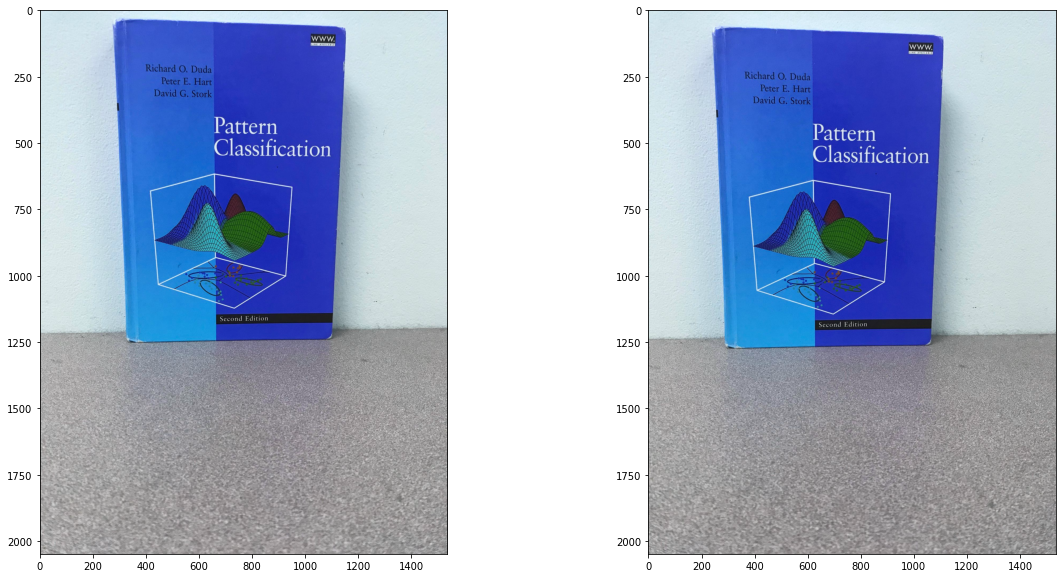

In [2]:
img1 = cv2.imread('books/front1.jpg')
img2 = cv2.imread('books/front2.jpg')

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(img1, cmap='gray')
plt.subplot(122)
plt.imshow(img2, cmap='gray')

plt.show()

In [3]:
# Use class for extracting keypoints and computing descriptors using the Scale Invariant Feature Transform (SIFT) in 2D
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)


# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 10)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.95*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [5]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c, d = img1.shape
#     img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
#     img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,8)
        img1 = cv2.circle(img1,tuple(pt1),40,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),40,color,-1)
    return img1,img2

In [6]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_RANSAC)
a = pts1
b = pts2
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

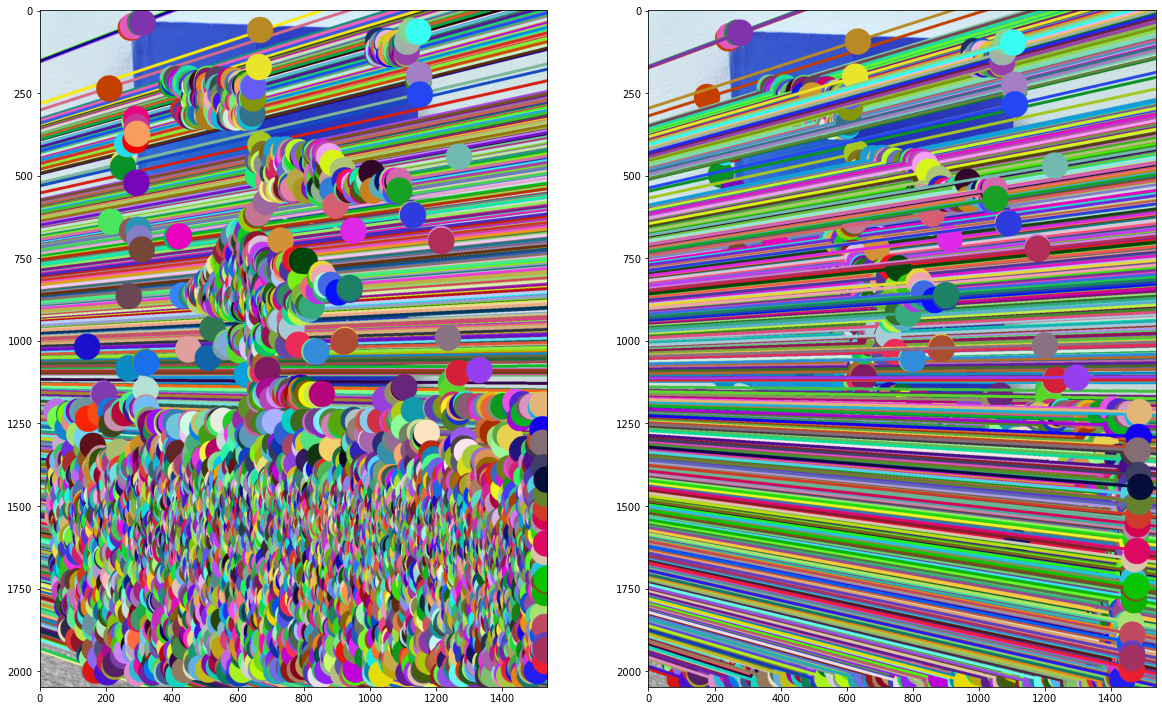

In [7]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
plt.figure(figsize=(20, 20))
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

## Fundamental Matrix

In [8]:
F

array([[ 9.71755820e-09,  2.04368256e-05, -2.24168077e-02],
       [-2.07230902e-05,  8.44791954e-07, -5.18531977e-02],
       [ 2.32064530e-02,  5.10251696e-02,  1.00000000e+00]])

#2. Estimate the extrinsic and intrinsic parameter from the fundamental matrix.

The camera matrix is unique to a specific camera, so once calculated, it can be reused on other images taken by the same camera. It is expressed as a 3x3 matrix. <br>

Extrinsic parameters corresponds to rotation and translation vectors which translates a coordinates of a 3D point to a coordinate system. <br>

Intrinsic parameter is given

In [9]:
camera_matrix = np.array([ [1497.44, 0, 767.17], [0, 1508.57, 1081.55], [0,0,1]])
camera_matrix

array([[1.49744e+03, 0.00000e+00, 7.67170e+02],
       [0.00000e+00, 1.50857e+03, 1.08155e+03],
       [0.00000e+00, 0.00000e+00, 1.00000e+00]])

c_x = 767.17 & c_y = 1081.55

Next, let's find the essential matrix

E = K' x F x K , where K is the camera matrix

In [10]:
c = a.astype(np.float32)
d = b.astype(np.float32)
ess_mat = cv2.findEssentialMat(c,d, camera_matrix)
ess_mat[0]

array([[-6.85268852e-04, -9.27978451e-02, -4.11026370e-02],
       [ 9.99644982e-02, -1.13151268e-02,  6.98790104e-01],
       [ 3.72800114e-02, -6.99822242e-01, -1.13644815e-02]])

In [11]:
U, S, V = np.linalg.svd(ess_mat[0])

In [14]:
V

array([[-0.        , -0.93134553, -0.36413664],
       [ 0.15088519, -0.35996775,  0.92068283],
       [ 0.98855129,  0.05494283, -0.14052624]])

E = S x R

we will decompose essential matrix into skew matrix and rotation matrix

# 3. Compute the world coordinates of the 4 corners of the book.

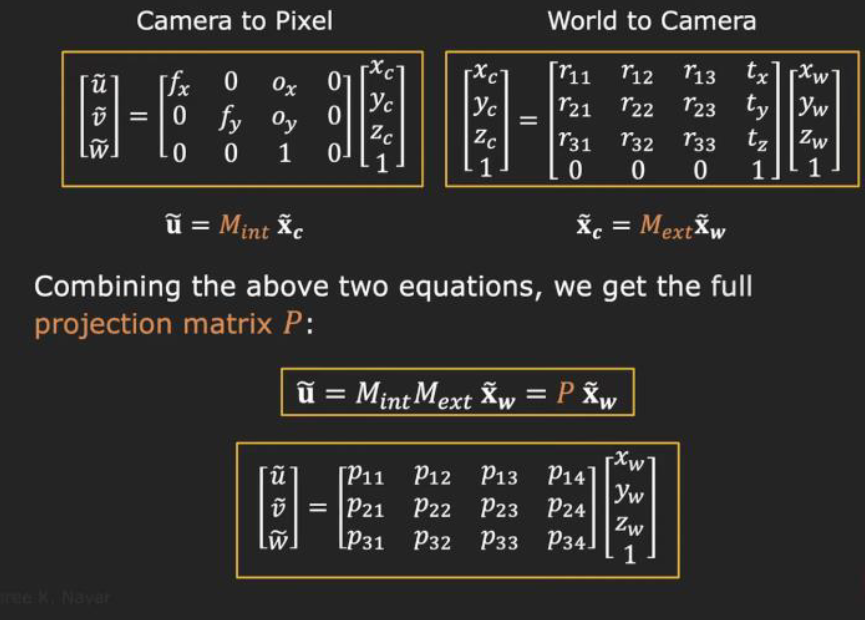

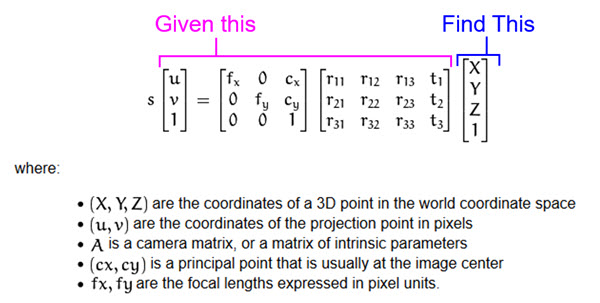

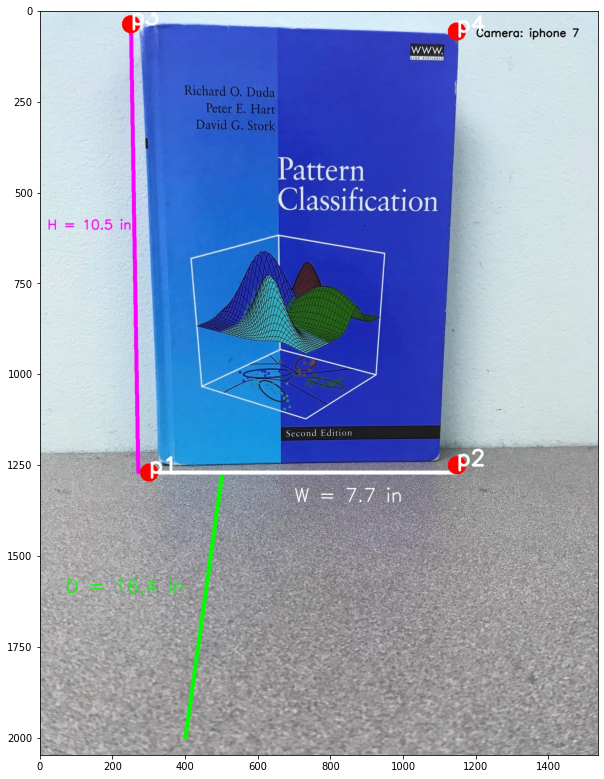

In [ ]:
img_dimns = cv2.imread('books/dimensions.jpg')

img_temp_2 = img_dimns.copy()
cv2.circle(img_temp_2, (300, 1270), radius=25, color=(255, 0, 0), thickness=-1)
cv2.circle(img_temp_2, (1147, 1250), radius=25, color=(255, 0, 0), thickness=-1)
cv2.circle(img_temp_2, (250, 36), radius=25, color=(255, 0, 0), thickness=-1)
cv2.circle(img_temp_2, (1147, 56), radius=25, color=(255, 0, 0), thickness=-1)


cv2.putText(img_temp_2, 'p1', (300, 1270), font, 2, [255, 255, 255], 5, cv2.LINE_AA)
cv2.putText(img_temp_2, 'p2', (1147, 1250), font, 2, [255, 255, 255], 5, cv2.LINE_AA)
cv2.putText(img_temp_2, 'p3', (250, 36), font, 2, [255, 255, 255], 5, cv2.LINE_AA)
cv2.putText(img_temp_2, 'p4', (1147, 56), font, 2, [255, 255, 255], 5, cv2.LINE_AA)


plt.figure(figsize=(10, 25))
plt.imshow(img_temp_2)

In [ ]:
p1 = (300, 1270, 1)
p2 = (1147, 1250, 1)
p3 = (250, 36, 1)
p4 = (1147, 56, 1)

In [ ]:
projection_matrix  = np.random.rand(3,4)
world_coordinate = np.random.rand(4,1)

img_coor = np.matmul(projection_matrix,world_coordinate)

In [ ]:
w1 = np.linalg.lstsq(projection_matrix, p1)
w2 = np.linalg.lstsq(projection_matrix, p2)
w2 = np.linalg.lstsq(projection_matrix, p3)
w3 = np.linalg.lstsq(projection_matrix, p4)

w1[0]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this 

array([ 1283.54663305,  3178.52437234, -2635.18927081, -2319.24656608])

# 4. Estimate the actual height and width of the object/book.

height = [ (p3-p1) + (p4-p2) ]/ 2   <br>
width =  [ (p2-p1) + (p4-p2) ]/ 2   <br>

# References

[1] Img coordinates to Real coordinate: https://www.fdxlabs.com/calculate-x-y-z-real-world-coordinates-from-a-single-camera-using-opencv/ <br>
[2] SVD : https://stackoverflow.com/questions/22807039/decomposition-of-essential-matrix-validation-of-the-four-possible-solutions-for

# Extra

In [ ]:
def calculate_XYZ(self,u,v):
                                      
        #Solve: From Image Pixels, find World Points

        uv_1=np.array([[u,v,1]], dtype=np.float32)
        uv_1=uv_1.T
        suv_1=self.scalingfactor*uv_1
        xyz_c=self.inverse_newcam_mtx.dot(suv_1)
        xyz_c=xyz_c-self.tvec1
        XYZ=self.inverse_R_mtx.dot(xyz_c)
        return XYZ

In [ ]:
cx = 767
cy = 1081

imagePoints=np.array([[cx,cy],
                       [502,185],
                       [700,197],
                       [894,208],
                       [491,331],
                       [695,342],
                       [896,353],
                       [478,487],
                       [691,497],
                       [900,508]], dtype=np.float32)

In [ ]:
X_center=10.9
Y_center=10.7
Z_center=43.4
worldPoints=np.array([[X_center,Y_center,Z_center],
                       [5.5,3.9,46.8],
                       [14.2,3.9,47.0],
                       [22.8,3.9,47.4],
                       [5.5,10.6,44.2],
                       [14.2,10.6,43.8],
                       [22.8,10.6,44.8],
                       [5.5,17.3,43],
                       [14.2,17.3,42.5],
                       [22.8,17.3,44.4]], dtype=np.float32)

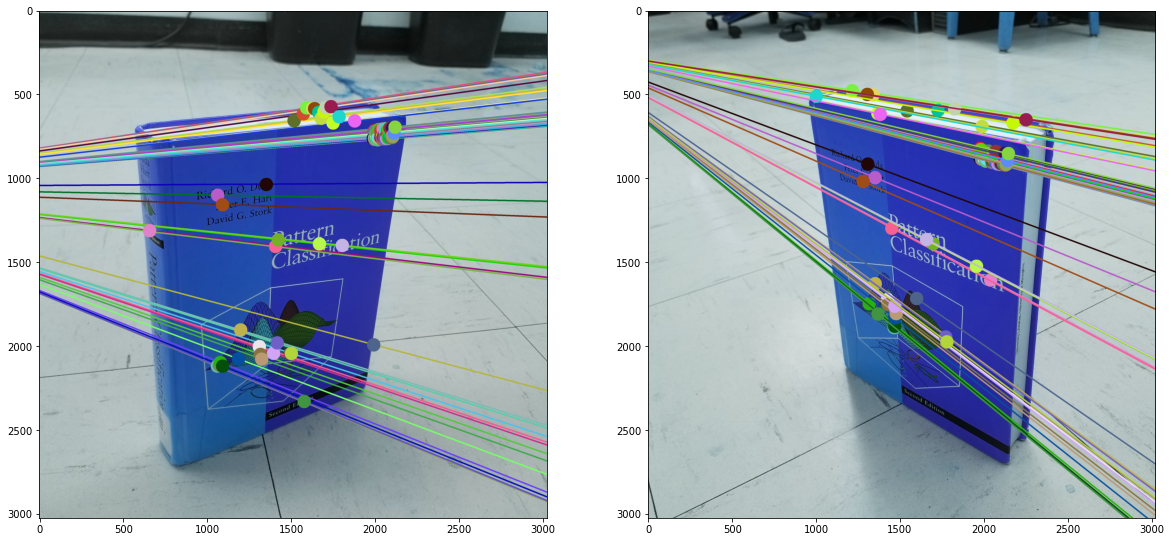

Intrinsic and Extrinsic Parameters (Camera Calibration)
----

Intrinsic parameters are specific to a camera. They include information like focal length (fx,fy) and optical centers (cx,cy). The focal length and optical centers can be used to create a camera matrix. The camera matrix is unique to a specific camera, so once calculated, it can be reused on other images taken by the same camera. It is expressed as a 3x3 matrix. Extrinsic parameters corresponds to rotation and translation vectors which translates a coordinates of a 3D point to a coordinate system.

11


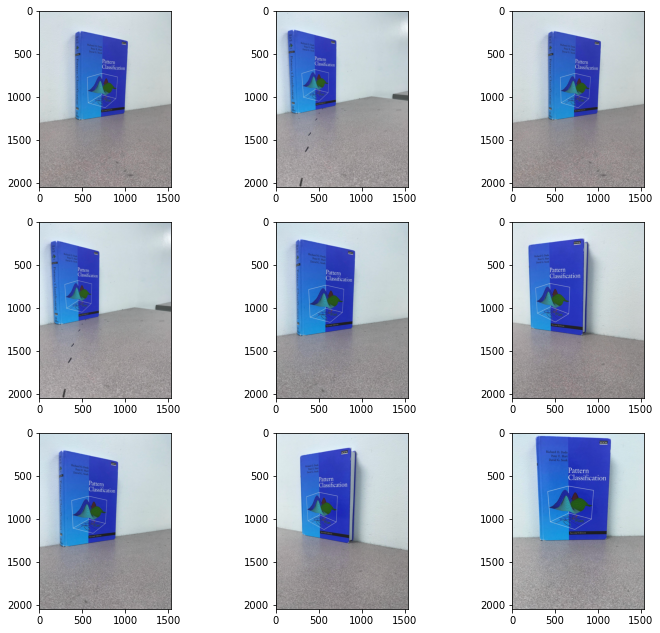

In [ ]:
paths = glob.glob('/content/drive/MyDrive/Graduate_School/Spring_2022/Image_Processing/Camera Calibration/*.jpg')
images = []
for fname in paths:
    img = cv2.imread(fname)
    images.append(img)

samples = np.random.randint(0, 10, 10)
print(len(images))


fig, axes = plt.subplots(3, 3, figsize=(12, 11))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[samples[i]], cmap='gray')

plt.show()

In [ ]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
corner_imgs = []
for img in images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (7,6), None)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        cv2.drawChessboardCorners(img, (7,6), corners2, ret)
        corner_imgs.append(img)

In [ ]:
len(corner_imgs)

0

In [ ]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [ ]:
mtx ## Intrinsic Parameters

array([[500.16864977,   0.        , 311.77030896],
       [  0.        , 501.44580932, 246.01427915],
       [  0.        ,   0.        ,   1.        ]])

In [ ]:
ess_mat = cv2.findEssentialMat(imgpoints[0], imgpoints[1], mtx)
ess_mat[0] ## Extrinsic Parameters 

array([[-0.05610743,  0.30327267, -0.006748  ],
       [ 0.49453952,  0.13020483, -0.48776965],
       [-0.1540462 ,  0.61733905,  0.02350559]])